## openEO Platform UC6 - Near Real Time Forest Dynamics

In [4]:
import openeo
from openeo.rest.datacube import PGNode, THIS
from openeo.processes import *
import math

In [5]:
backend = "openeo.cloud"
conn = openeo.connect(backend)
conn = conn.authenticate_oidc()

Authenticated using refresh token.


In [6]:
spatial_extents = [
    [11.3, 46.3, 11.35, 46.35],
    [11.35, 46.3, 11.4, 46.35],
    [11.4, 46.3, 11.45, 46.35]
]

#### To not take up all the resources on production and keep the processing reliable, it makes sense to only submit 3 jobs at once. 

In [7]:
def fit_process(bbox):
    spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
    temporal_extent = ["2016-09-01", "2018-09-01"] 
    collection      = 'boa_sentinel_2'
    bands           = ["B02", "B03", "B04", "B05", "B08"] 

    l2a_bands = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

    l2a_bands_clipped = l2a_bands.apply(lambda x: x.clip(0,5000))

    def fitFunction(x, parameters):
        t = 2 * math.pi / 31557600 * x
        return parameters[0] + parameters[1] * cos(t) + parameters[2] * sin(t)

    curve_fitting = l2a_bands_clipped.fit_curve(
        parameters=[1,1,1],
        dimension="t",
        function=fitFunction
    )
    fitted_parameters = curve_fitting.save_result(format="NetCDF")
    return fitted_parameters

In [8]:
job_ids = []
for bbox in spatial_extents: 
    fitted_parameters = fit_process(bbox)
    job = fitted_parameters.create_job(title = "UC6-1")
    jobIdFitting = job.job_id
    job.start_job()
    job_ids.append(jobIdFitting)
print("Jobs submitted: ", job_ids)

Jobs submitted:  ['eodc-e361e7eb-4946-42cd-a388-fd211a6f9c25', 'eodc-90d3d6a8-5039-4b8d-ad75-799600848c60', 'eodc-b1f2e0fd-ad2d-484e-92b1-bd34bb360297']


In [9]:
job

<BatchJob job_id='eodc-b1f2e0fd-ad2d-484e-92b1-bd34bb360297'>

### Change Detection

In [16]:
def change_detection_process(job_id, bbox):
    spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
    temporal_extent = ["2016-09-01", "2018-09-01"] 
    collection      = 'boa_sentinel_2'
    bands           = ["B02", "B03", "B04", "B05", "B08"] 

    l2a_bands = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

    l2a_bands_clipped = l2a_bands.apply(lambda x: x.clip(0,5000))

    def fitFunction(x, parameters):
        t = 2 * math.pi / 31557600 * x
        return parameters[0] + parameters[1] * cos(t) + parameters[2] * sin(t)
    
    
    curve_fitting_loaded = conn.load_stac(url = f'{backend}/jobs/{job_id}/results')
    
    temporal_labels =  l2a_bands_clipped.dimension_labels('t')
    curve_prediction = curve_fitting_loaded.predict_curve(parameters= curve_fitting_loaded, dimension= 't', function= fitFunction, labels= temporal_labels)
    
    force_cloud_mask = l2a_bands.apply(lambda x: x.gt(0))
    predicted_masked = curve_prediction.merge_cubes(force_cloud_mask,overlap_resolver=multiply)
    merged_cubes = l2a_bands_clipped.merge_cubes(predicted_masked,overlap_resolver=subtract)
    
    mse = merged_cubes.band("B02")**2 + merged_cubes.band("B03")**2 + merged_cubes.band("B04")**2 + merged_cubes.band("B05")**2 + merged_cubes.band("B08")**2
    rmse = (mse/5)**0.5
    
    rmse_std = rmse.reduce_dimension(dimension='t',reducer=sd)
    
    rmse_std_netcdf = rmse_std.save_result(format="NetCDF")
    return rmse_std_netcdf

In [18]:
job_ids_change_detection = []
for i, job_id in enumerate(job_ids): 
    rmse_std_netcdf = change_detection_process(job_id, spatial_extents[i])
    job = rmse_std_netcdf.create_job(title = "UC6-2")
    jobIdPrediction = job.job_id
    job.start_job()
    job_ids_change_detection.append(jobIdPrediction)
print("Jobs submitted: ", job_ids_change_detection)

Jobs submitted:  ['eodc-38b20ba3-e5fb-43e6-820b-fde86e439b2f', 'eodc-f442439a-1c47-4cbc-b6ea-156c62226605', 'eodc-dea471f5-738e-4924-a37f-b5e1db1a9bf2']


In [19]:
job

<BatchJob job_id='eodc-dea471f5-738e-4924-a37f-b5e1db1a9bf2'>

### Change Detection for 2019

In [23]:
def change_detection_prediction_process(job_id, bbox, job_id_change_detection):
    spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
    temporal_extent = ["2018-10-01", "2019-03-01"] 
    collection      = 'boa_sentinel_2'
    bands           = ["B02","B03","B04","B05","B08"]

    l2a_bands_test = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)
    
    l2a_bands_test_clipped = l2a_bands_test.apply(lambda x: x.clip(0,5000))
    
    def fitFunction(x, parameters):
        t = 2 * math.pi / 31557600 * x
        return parameters[0] + parameters[1] * cos(t) + parameters[2] * sin(t)

    curve_fitting_loaded = conn.load_stac(url = f'{backend}/jobs/{job_id}/results')
    
    temporal_labels =  l2a_bands_test_clipped.dimension_labels('t')
    curve_prediction_test = curve_fitting_loaded.predict_curve(parameters= curve_fitting_loaded, dimension= 't', function= fitFunction, labels= temporal_labels)
    
    force_cloud_mask_test = l2a_bands_test.apply(lambda x: x.gt(0))
    predicted_masked_test = curve_prediction_test.merge_cubes(force_cloud_mask_test,overlap_resolver=multiply)
    
    merged_cubes_test = l2a_bands_test_clipped.merge_cubes(predicted_masked_test,overlap_resolver=subtract)
    mse = merged_cubes_test.band("B02")**2 + merged_cubes_test.band("B03")**2 + merged_cubes_test.band("B04")**2 + merged_cubes_test.band("B05")**2 + merged_cubes_test.band("B08")**2
    rmse = (mse/5)**0.5
    
    
    training_std_loaded = conn.load_stac(url = f'{backend}/jobs/{job_id_change_detection}/results')
    
    alarm_threshhold = training_std_loaded.apply(lambda x: x * 3)
    alarm_cubes = rmse.merge_cubes(alarm_threshhold,overlap_resolver=gt)
    alarm_cubes_netcdf = alarm_cubes.save_result(format="NetCDF" , options={"tile_grid":"time-series"})
    
    return alarm_cubes_netcdf

In [24]:
job_ids_change_detection_2019 = []
for i, job_id in enumerate(job_ids): 
    alarm_cubes_netcdf = change_detection_prediction_process(job_id, spatial_extents[i], job_ids_change_detection[i])
    job = alarm_cubes_netcdf.create_job(title = "UC6-2")
    jobIdAlarms = job.job_id
    job.start_job()
    job_ids_change_detection_2019.append(jobIdAlarms)
print("Jobs submitted: ", job_ids_change_detection_2019)

Jobs submitted:  ['eodc-bb2f9b43-f287-4ef2-a516-7718cb398187', 'eodc-c2fc51ff-6531-4d02-9471-f136c12f5bf0', 'eodc-c059d9dd-9d79-4e27-927e-e021fc0ee15f']


In [25]:
job

<BatchJob job_id='eodc-c059d9dd-9d79-4e27-927e-e021fc0ee15f'>

In [26]:
job = conn.job("eodc-a013e229-e739-449a-a6f5-c837085b6239")
job

<BatchJob job_id='eodc-a013e229-e739-449a-a6f5-c837085b6239'>

In [1]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./UC6/")

<xarray.DataArray (bands: 1, y: 247, x: 189)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
    t            datetime64[ns] ...
  * y            (y) float64 1.463e+06 1.463e+06 1.463e+06 ... 1.46e+06 1.46e+06
  * x            (x) float64 4.861e+06 4.861e+06 ... 4.863e+06 4.863e+06
    spatial_ref  int32 ...
  * bands        (bands) object 'name'
Attributes:
    nodata:   -9999
    crs:      PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984"...

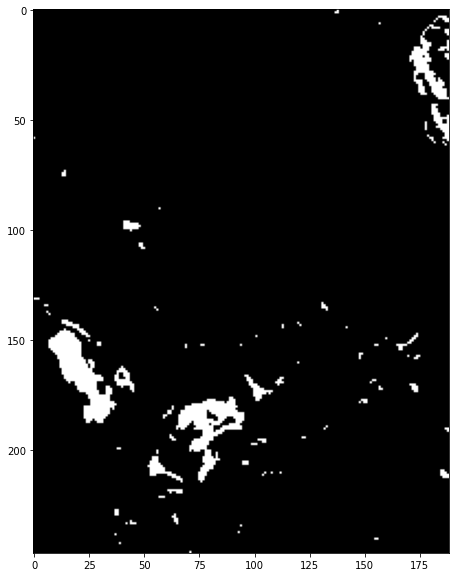

In [43]:
# really basic test to see if the results are actually as expected

import xarray as xr
import matplotlib.pyplot as plt

file = # insert path here
D = xr.open_dataset(file)
d = D.to_array(dim="bands")

plt.figure(figsize=(10,10))
plt.imshow(d.isel(bands=0, t=0), cmap="gray")

display(d)